---
### **Projeto 2: Segmentaçãode clientes a partir de dados históricos**
Ciência de Dados e Inteligência Artificial - PUC-SP

Pontifícia Universidade Católica de São Paulo 
> *Marina Rodrigues - RA 00274375*

---
## **Sumário**
#### **1. Introdução**
#### **2. Pré-Processamento**
> ##### 2.1 Importação de bibliotecas
> ##### 2.2 Importação do dataset
> ##### 2.3 Distribuição de clientes por idade
> ##### 2.4 Percentual de clientes inadimplentes
> ##### 2.5 Distribuição de Renda
> ##### 2.6 Distribuição de Razão débito-renda
#### **3. Segmentação dos clientes**
> ##### 3.1 Normalização do dataset
> ##### 3.2 Método Elbow: melhor valor de k
> ##### 3.3 Segmentação por K-Means
> ##### 3.4 Análise do centroide dos dados

---
#### **1. Introdução**

A segmentação de clientes é a prática de particionar uma base de  clientes  em  grupos  de  indivíduos  com  características  semelhantes.  É uma  estratégia significativa, pois uma empresa pode ter como alvo esses grupos específicos de clientes e alocar recursos  de  marketing  de  forma  eficaz.  

Por  exemplo,  um  grupo  pode  conter  clientes  de  alto lucro  e  baixo  risco,  ou  seja,  mais  propensos  a  comprar  produtos  ou  assinar  um  serviço.  Uma tarefa empresarial é reter esses clientes. Neste projeto, é apresentado um conjunto de dados do cliente e é preciso aplicar a segmentação do cliente a esses dados históricos.  

---
#### **2. Pré-processamento**

##### **2.1 Importação de bibliotecas**


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix
from scipy.cluster import hierarchy
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')
from pyspark.sql import *

##### **2.2 Importação do dataset**


O que o Dataset nos informa:

* "ID do cliente", "Idade", "Educação", "Anos de emprego", "Renda", "Dívida do cartão", "Outras dívidas", "Inadimplente", "Razão débito-renda".

* Todas as colunas são numéricas, com exceção da "Educação" e "Inadimplente" que são categóricas.

In [84]:
df = pd.read_csv('/content/dados.csv')
df

,Unnamed: 0,ID do cliente,Idade,Educação,Anos de emprego,Renda,Dívida do cartão,Outras dívidas,Inadimplente,Razão débito-renda
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2
...,...,...,...,...,...,...,...,...,...,...
845,845,846,27,1,5,26,0.548,1.220,NaN,6.8
846,846,847,28,2,7,34,0.359,2.021,0.0,7.0
847,847,848,25,4,0,18,2.802,3.210,1.0,33.4
848,848,849,32,1,12,28,0.116,0.696,0.0,2.9


In [85]:
df.describe()

,Unnamed: 0,ID do cliente,Idade,Educação,Anos de emprego,Renda,Dívida do cartão,Outras dívidas,Inadimplente,Razão débito-renda
count,850.00000,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,424.50000,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,0.00000,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,212.25000,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,424.50000,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,636.75000,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,849.00000,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


Pelo `describe()` é possível receber algumas informações sobre o dataset, que serão visualizadas por meio dos gráficos abaixo. Como por exemplo, a média de algumas colunas:

* Idade média: 35 anos, sendo o mínimo 20 anos, e máximo de 56 anos.
* Média de anos no emprego: 9 anos, sendo o mínimo menos de 1 ano, e máximo de 33 anos.
* Renda média: 47



##### **2.3 Distribuição de clientes por idade**


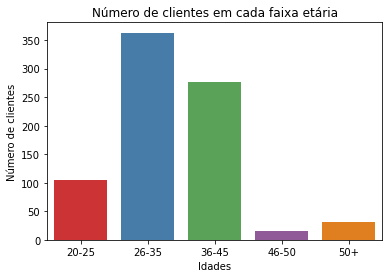

In [86]:
def faixa_et():
  i20_25 = df.Idade[(df.Idade <= 25) & (df.Idade >= 20)]
  i26_35 = df.Idade[(df.Idade <= 35) & (df.Idade >= 26)]
  i36_45 = df.Idade[(df.Idade <= 45) & (df.Idade >= 36)]
  i46_50 = df.Idade[(df.Idade <= 50) & (df.Idade >= 49)]
  i50 = df.Idade[df.Idade >= 51]
  idades = ["20-25","26-35","36-45","46-50","50+"]
  valores = [len(i20_25.values),len(i26_35.values),len(i36_45.values),len(i46_50.values),len(i50.values)]
  sns.barplot(x = idades, y = valores, palette="Set1")
  plt.title("Número de clientes em cada faixa etária")
  plt.xlabel("Idades")
  plt.ylabel("Número de clientes")
  plt.show()

faixa_et()

Como visto anteriormente, a média de idade dos clientes é de 35 anos, logo a maior parte dos clientes estarão nas faixas etárias de 26-45 anos.

##### **2.4 Percentual de clientes inadimplentes**

In [87]:
df['Inadimplente'] = df['Inadimplente'].fillna(0)

P = df.groupby('Inadimplente')['Unnamed: 0'].count().reset_index()
P['Percentage'] = 100 * P['Unnamed: 0']  / P['Unnamed: 0'].sum()
P.drop('Unnamed: 0', axis=1, inplace=True)

def pie():
  la = ['Adimplente', 'Inadimplente']
  co = ['mediumseagreen','firebrick']
  plt.pie(P['Percentage'], labels = la, colors = co)
  plt.show()

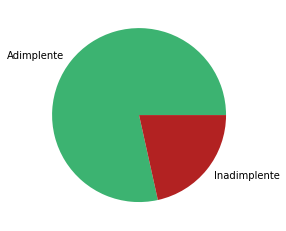

   Inadimplente  Percentage
0           0.0   78.470588
1           1.0   21.529412


In [88]:
pie()
print(P)

A maior parte dos clientes, contabilizando 78,5% do dataset, são adimplentes. Enquanto isso, 21,5% são inadimplentes.

##### **2.5 Distribuição de Renda**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


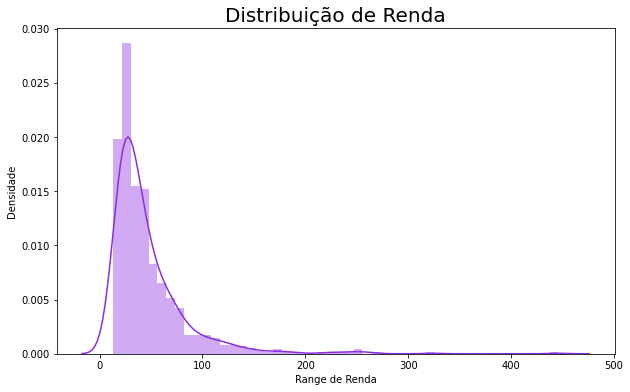

In [89]:
def renda():
  plt.figure(figsize=(10, 6))
  sns.distplot(df['Renda'], color = 'blueviolet')
  plt.title('Distribuição de Renda', fontsize = 20)
  plt.xlabel('Range de Renda')
  plt.ylabel('Densidade')

renda()

A maioria da renda dos clientes cai na faixa de 0 até 100, sendo a média de 47.

##### **2.6 Distribuição de Razão débito-renda**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


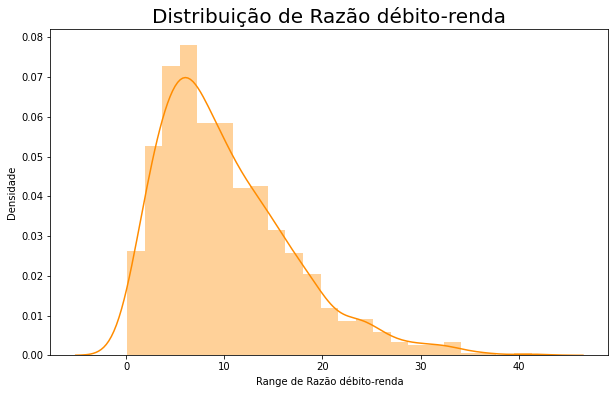

In [90]:
def razao():
  plt.figure(figsize=(10, 6))
  sns.distplot(df['Razão débito-renda'], color = 'darkorange')
  plt.title('Distribuição de Razão débito-renda', fontsize = 20)
  plt.xlabel('Range de Razão débito-renda')
  plt.ylabel('Densidade')

razao()

Enquanto isso, a distribuição da Razão débito-renda está entre 5 e 15, com uma média de 10.

---
#### **3. Segmentação dos clientes**

##### **3.1 Normalização do dataset**

In [91]:
data = np.array(df)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

##### **3.2 Método Elbow: melhor valor de k**

In [92]:
soma = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_data)
    soma.append(km.inertia_)

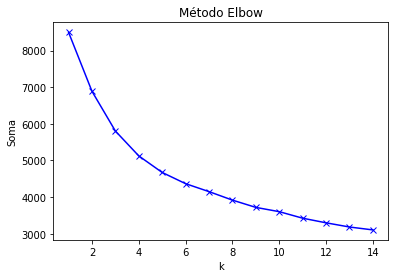

In [93]:
plt.plot(K, soma, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma')
plt.title('Método Elbow')
plt.show()

De acordo com o método elbow, será utilizado o valor de `k = 5`.

##### **3.3 Segmentação por K-Means**

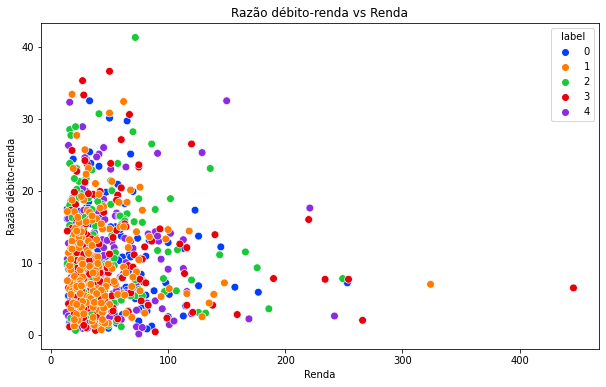

In [94]:
X = df[['Renda','Razão débito-renda']]

km = KMeans(n_clusters=5)
km.fit(X)
y=km.predict(X)
clusters = km.fit_predict(df.iloc[:,1:])
df["label"] = clusters

plt.figure(figsize=(10,6))
sns.scatterplot(x = 'Renda',y = 'Razão débito-renda',hue="label", palette='bright', legend='full', data = df  ,s = 60 )
plt.xlabel('Renda')
plt.ylabel('Razão débito-renda') 
plt.title('Razão débito-renda vs Renda')
plt.show()

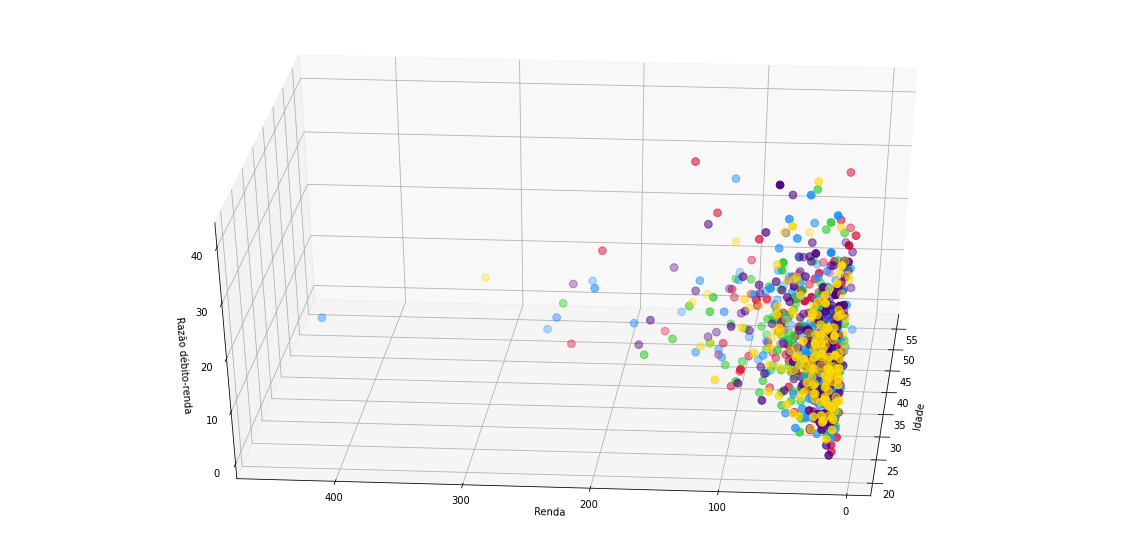

In [95]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df.Idade[df.label == 0], df["Renda"][df.label == 0], df["Razão débito-renda"][df.label == 0], c='limegreen', s=60)
ax.scatter(df.Idade[df.label == 1], df["Renda"][df.label == 1], df["Razão débito-renda"][df.label == 1], c='gold', s=60)
ax.scatter(df.Idade[df.label == 2], df["Renda"][df.label == 2], df["Razão débito-renda"][df.label == 2], c='indigo', s=60)
ax.scatter(df.Idade[df.label == 3], df["Renda"][df.label == 3], df["Razão débito-renda"][df.label == 3], c='dodgerblue', s=60)
ax.scatter(df.Idade[df.label == 4], df["Renda"][df.label == 4], df["Razão débito-renda"][df.label == 4], c='crimson', s=60)
ax.view_init(35, 185)
plt.xlabel("Idade")
plt.ylabel("Renda")
ax.set_zlabel('Razão débito-renda')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


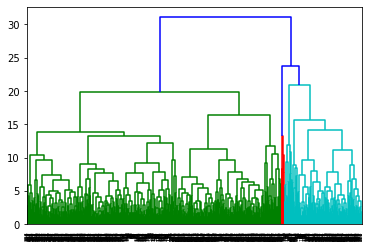

In [81]:
scaler2 = MinMaxScaler()
done = scaler2.fit_transform(df)
dm = distance_matrix(done, done)
Z = hierarchy.linkage(dm, 'complete')
dendro = hierarchy.dendrogram(Z)

##### **3.4 Análise do centroide dos dados**

Adicione o grupo sugerido pelo algoritmo àuma nova coluna do Datasete faça uma análise do centroide dosdados agregados por grupos.Escreva comentários sobre os insights que você obtevecom essa análise.

In [82]:
clientes0=df[df["label"]==0]
print('Número de clientes no grupo 0 =', len(clientes0))
clientes1=df[df["label"]==1]
print('Número de clientes no grupo 1 =', len(clientes1))
clientes2=df[df["label"]==2]
print('Número de clientes no grupo 2 =', len(clientes2))
clientes3=df[df["label"]==3]
print('Número de clientes no grupo 3 =', len(clientes3))
clientes4=df[df["label"]==4]
print('Número de clientes no grupo 4 =', len(clientes4))

df["label"] = y
df

Número de clientes no grupo 0 = 170
Número de clientes no grupo 1 = 169
Número de clientes no grupo 2 = 172
Número de clientes no grupo 3 = 168
Número de clientes no grupo 4 = 171


,Unnamed: 0,ID do cliente,Idade,Educação,Anos de emprego,Renda,Dívida do cartão,Outras dívidas,Inadimplente,Razão débito-renda,label
0,0,1,41,2,6,19,0.124,1.073,0.0,6.3,0
1,1,2,47,1,26,100,4.582,8.218,0.0,12.8,3
2,2,3,33,2,10,57,6.111,5.802,1.0,20.9,4
3,3,4,29,2,4,19,0.681,0.516,0.0,6.3,0
4,4,5,47,1,31,253,9.308,8.908,0.0,7.2,1
...,...,...,...,...,...,...,...,...,...,...,...
845,845,846,27,1,5,26,0.548,1.220,0.0,6.8,0
846,846,847,28,2,7,34,0.359,2.021,0.0,7.0,0
847,847,848,25,4,0,18,2.802,3.210,1.0,33.4,0
848,848,849,32,1,12,28,0.116,0.696,0.0,2.9,0


O cluster com o maior número de clientes é o grupo 0 com 421 clientes, seguido pelo grupo 4 com 252, e o grupo 1 com 125 clientes.

---

